# Essential

## import packages

In [1]:
import numpy as np
import idx2numpy

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from scipy import interpolate

import time

## execution time wrapper

In [2]:
def calculate_execution_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Execution time of {func.__name__}: {end_time - start_time} seconds")
        return result
    return wrapper

## class for the Activation functions

In [3]:
class Activation:
    def __init__(self, name, alpha=1):
        self.name = name
        if name == 'sigmoid':
            self.function = self.exponent
            self.derivative = self.exponent_der
        elif name == 'tanh':
            self.function = lambda x: np.tanh(x)
            self.derivative = lambda x: 1 - np.square(np.tanh(x))
        elif name == 'softmax':
            self.function = self.softmax
            self.derivative = self.softmax_der
        elif name == 'relu':
            self.function = lambda x: np.maximum(0, x)
            self.derivative = lambda x: x >= 0
        elif name == 'lrelu':
            self.function = lambda x: np.maximum(0.0001, x) 
            self.derivative = lambda x: np.where(x >= 0, 1, 0.0001)
        elif name == 'elu':
            self.function = lambda x: np.where(x >= 0, x, alpha*(np.exp(x) - 1))
            self.derivative = lambda x: np.where(x >= 0, 1, self.function(x) + alpha)
        
    def exponent(self, x):
        shift_x = x - np.max(x)
        return 1/(1 + np.exp(-shift_x))
    
    def exponent_der(self, x):
        exps = self.exponent(x)
        return exps * (1 - exps)
    
    def softmax(self, x):
        shift_x = x - np.max(x)
        exps = np.exp(shift_x)
        return exps/np.sum(exps)
    
    def softmax_der(self, x):
        array = self.softmax(x).reshape(-1,1)
        return np.diagflat(array) - np.dot(array, array.T)

# Model creation

## Convolution layer

In [4]:
class Conv:

    def __init__(self, num_filters = 3, size = 3, stride = 1, activation = 'relu'):
        self.next_layer = None
        self.num_filters = num_filters
        self.size = size
        self.stride = stride
        self.activation = Activation(activation)

        self.filters = np.random.randn(num_filters, size, size) / 10
    
    def add_layer(self, child):
        self.next_layer = child
        return self
    
    # @calculate_execution_time            
    def forward(self, image):
        self.last_input = image
        input_dimension = image.shape[1]
        output_dimension = int((input_dimension - self.size) / self.stride) + 1
        output = np.zeros((self.filters.shape[0], output_dimension, output_dimension))
        
        for f in range(self.num_filters):
            current_y = output_y = 0
            
            while current_y + self.size <= input_dimension:
                current_x = output_x = 0
                
                while current_x + self.size <= input_dimension:
                    patch = image[:, current_y:current_y + self.size, current_x:current_x + self.size]
                    output[f, output_y, output_x] = np.sum(self.filters[f] * patch)
                    current_x += self.stride
                    output_x += 1
                    
                current_y += self.stride
                output_y += 1
        
        output = self.last_output = self.activation.function(output)
        return output
    
    # @calculate_execution_time
    def backward(self, out_prev, lr):
        out_prev = np.clip(out_prev, -1e+5, 1e+5)
        input_dimension = self.last_input.shape[1]
        
        out_prev = out_prev * self.last_output
        
        out_next = np.zeros(self.last_input.shape)
        dfilt = np.zeros(self.filters.shape)
        
        for f in range(self.filters.shape[0]):
            current_y = output_y = 0
            
            while current_y + self.size <= input_dimension:
                current_x = output_x = 0
                
                while current_x + self.size <= input_dimension:
                    patch = self.last_input[:, current_y:current_y + self.size, current_x:current_x + self.size]
                    dfilt[f] += np.sum(out_prev[f, output_y, output_x] * patch, axis=0)
                    out_next[:, current_y:current_y + self.size, current_x:current_x + self.size] += out_prev[f, output_y, output_x] * self.filters[f]
                    current_x += self.stride
                    output_x += 1
                    
                current_y += self.stride
                output_y += 1
                
        self.filters -= lr * dfilt
        return out_next

## Pool method

In [5]:
class MaxPool:
    
    def __init__(self, size = 2, stride = 2, activation = 'relu'):
        self.next_layer = None
        self.stride = stride
        self.size = size
        self.activation = Activation(activation)
    
    def add_layer(self, child):
        self.next_layer = child
        return self
    
    # @calculate_execution_time            
    def forward(self, image):
        self.last_input = image
        
        nfilt, h_prev, w_prev = image.shape
        h = int((h_prev - self.size) / self.stride) + 1
        w = int((w_prev - self.size) / self.stride) + 1
        
        downscaled = np.zeros((nfilt, h, w))
        
        for i in range(nfilt):
            curr_y = output_y = 0
            
            while curr_y + self.size <= h_prev:
                curr_x = output_x = 0
                
                while curr_x + self.size <= w_prev:
                    patch = image[i, curr_y:curr_y + self.size, curr_x:curr_x + self.size]
                    downscaled[i, output_y, output_x] = np.max(patch)
                    curr_x += self.stride
                    output_x += 1
                    
                curr_y += self.stride
                output_y += 1
                
        return downscaled
    # @calculate_execution_time
    def backward(self, out_prev, learning_rate):
        out_prev = np.clip(out_prev, -1e+5, 1e+5)
        out_next = np.zeros(self.last_input.shape)

        nfilt, shape, _ = self.last_input.shape
        
        for c in range(nfilt):
            current_y = output_y = 0
            while current_y + self.size <= shape:
                current_x = output_x = 0
                while current_x + self.size <= shape:
                    patch = self.last_input[c, current_y:current_y + self.size, current_x:current_x + self.size]
                    (x, y) = np.unravel_index(np.nanargmax(patch), patch.shape)
                    out_next[c, current_y + x, current_x + y] += out_prev[c, output_y, output_x]
                    current_x += self.stride
                    output_x += 1
                current_y += self.stride
                output_y += 1
        return out_next

## FCL Layer

In [6]:
class FCL:
    def __init__(self, n_inputs, n_neurons, activation):
        self.next_layer = None
        
        self.weights = np.random.randn(n_inputs, n_neurons) / 10
        self.biases = np.random.randn(n_neurons) / 10
        
        self.activation = Activation(activation)

    def add_layer(self, child):
        self.next_layer = child
        return self
    
    # @calculate_execution_time
    def forward(self, image):
        self.last_input_shape = image.shape
        image = image.flatten()
        output = np.dot(image, self.weights) + self.biases
        self.last_input = image
        self.last_output = output
        return self.activation.function(output)
    
    # @calculate_execution_time
    def backward(self, out_prev, learning_rate):
        out_prev = np.clip(out_prev, -1e+5, 1e+5)
        
        if self.next_layer is None:
            dW = out_prev[:, np.newaxis]
        else:
            dW = out_prev[:, np.newaxis] * self.activation.derivative(self.last_output)[:, np.newaxis]
        dW = (dW * self.last_input[np.newaxis, :]).T
        db = np.copy(out_prev)
        out_next = self.weights @ out_prev
        self.weights -= learning_rate * dW
        self.biases -= learning_rate * db
        return out_next.reshape(self.last_input_shape)

## CNN

In [7]:
class Main_Model:
    
    def __init__(self, layers):
        if len(layers) < 2:
            raise ValueError("Not enough layers. Should be at least 2")
        
        self.layers = [layers[0]]
        
        for layer in layers[1:]:
            self.layers[-1].add_layer(layer)
            if layer is not None and layer not in self.layers:
                self.layers.append(layer)
        
        self.early_stop = None
        
    # @calculate_execution_time
    def forward(self, image):
        for layer in self.layers:
            image = layer.forward(image)
        return image
    
    # @calculate_execution_time
    def backward(self, gradient, learning_rate):
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient, learning_rate)

    def train(self, X_train, y_train, X_val = None, y_val = None, epochs=10, learning_rate=0.1, lr_decay=0, step=50, val_step=100):
        data_amount = X_train.shape[0]
        num_digits = len(str(data_amount))
        learning_rate_0 = learning_rate
            
        for epoch in range(epochs):
            accuracies = []
            losses = []
            
            self.history['accuracy'][epoch] = []
            self.history['loss'][epoch] = []
                
            self.history['val_accuracy'][epoch] = []
            self.history['val_loss'][epoch] = []
            
            for i, X in enumerate(X_train):              
                output = self.forward(X)
                
                accuracy = output[np.argmax(y_train[i])]
                loss = -np.sum(y_train[i] * np.log(output))
                accuracies.append(accuracy)
                losses.append(loss)
                
                gradient = np.copy(output) - y_train[i]
                self.backward(gradient, learning_rate)
                
                learning_rate = (1/(1+lr_decay*((epoch + 1) * (i + 1)))) * learning_rate_0
                
                if i % step == 0:
                    avg_accuracy = np.mean(accuracies)
                    avg_loss = np.mean(losses)
                    
                    accuracies = []
                    losses = []
                    
                    if self.early_stop is not None:
                        if self.EarlyStopping(epoch, i, avg_accuracy, avg_loss, step, val_step, X_val, y_val):
                            self.output = np.array(output)
                            return
                    
                    if i > val_step:
                        val_accuracy, val_loss = self.history['val_accuracy'][epoch][-1], self.history['val_loss'][epoch][-1]
                        
                        print(f'[Image {i:{num_digits}d}]: ' +
                            f'Avg Acc: {avg_accuracy:7.2%} | ' +
                            f'Avg Loss {avg_loss:5.2f} | ' +
                            f'Val Acc: {val_accuracy:7.2%} | '+
                            f'Val Loss: {val_loss:5.2f}')
                          

    def val_pred(self, X_val, y_val):
        accuracies = []
        losses = []
        
        for i, X in enumerate(X_val):
            current_output = self.forward(X)
            
            accuracy = current_output[np.argmax(y_val[i])]
            loss = -np.sum(y_val[i] * np.log(current_output))
            accuracies.append(accuracy)
            losses.append(loss)
            
        return np.mean(accuracies), np.mean(losses)
        
    def predict(self, X):
        return np.array([np.argmax(self.forward(x), 0) for x in X])
        
    def EarlyStop(self, monitor="accuracy", min_delta=.1, min_monitor = 0.6, patience=3, restore_best_layers=False):
        self.early_stop = {
            "monitor": monitor, 
            "min_delta": min_delta, 
            "min_monitor": min_monitor, 
            "patience": patience,
            "restore_best_layers": restore_best_layers,
        }
        
        self.history = {
            "accuracy": {},
            "loss": {},
            'val_accuracy': {},
            'val_loss': {},
            "global_max_index": (0, 0),
            "best_layers": []
        }
    
    def EarlyStopping(self, epoch, im_i, accuracy, loss, step, val_step, X_val=None, y_val=None):
        
        im_i = int(im_i/step) - 1
        
        self.history['accuracy'][epoch].append(accuracy)
        self.history['loss'][epoch].append(loss)
        
        val_accuracy, val_loss = self.val_pred(X_val, y_val)
        self.history['val_accuracy'][epoch].append(val_accuracy)
        self.history['val_loss'][epoch].append(val_loss)
        
        if ((epoch + 1) * (im_i + 1)) > self.early_stop['patience']:
            
            if self.history[self.early_stop['monitor']][epoch][-1] >= self.history[self.early_stop['monitor']][self.history['global_max_index'][0]][self.history['global_max_index'][1]]:
                self.history['global_max_index'] = (epoch, im_i)
            
            if self.early_stop['restore_best_layers'] and (epoch, im_i) == self.history['global_max_index']:
                self.history['best_layers'] = []
                for layer in self.layers:
                    if layer.__class__.__name__ == 'Conv':
                        self.history['best_layers'].append(layer.filters)
                    elif layer.__class__.__name__ == 'MaxPool':
                        self.history['best_layers'].append(None)
                    elif layer.__class__.__name__ == 'FCL':
                        self.history['best_layers'].append((layer.weights, layer.biases))
                
            min_local_accuracy = min(self.history[self.early_stop['monitor']][epoch][-self.early_stop['patience']:])
            difference = abs(min_local_accuracy - self.history[self.early_stop['monitor']][self.history['global_max_index'][0]][self.history['global_max_index'][1]])
            
            if min_local_accuracy >= self.early_stop['min_monitor'] and difference < self.early_stop['min_delta']:
                if self.early_stop['restore_best_layers']:
                    for i, layer in enumerate(self.layers):
                        if layer.__class__.__name__ == 'Conv':
                            layer.filters = self.history['best_layers'][i]
                        elif layer.__class__.__name__ == 'MaxPool':
                            continue
                        elif layer.__class__.__name__ == 'FCL':
                            layer.weights, layer.biases = self.history['best_layers'][i]
                return True
        return False
    
    def restore_best_layers(self):
        if self.early_stop['restore_best_layers']:
            for i, layer in enumerate(self.layers):
                if layer.__class__.__name__ == 'Conv':
                    layer.filters = self.history['best_layers'][i]
                elif layer.__class__.__name__ == 'MaxPool':
                    continue
                elif layer.__class__.__name__ == 'FCL':
                    layer.weights, layer.biases = self.history['best_layers'][i]

## Training

### import data

In [8]:
# # data = pd.read_csv("train.csv").sample(frac=.05).to_numpy()
# X = idx2numpy.convert_from_file('D:\\Programming\\Projects\\data_sets\\num_mnist_X.idx3-ubyte').astype('float32')
# Y = idx2numpy.convert_from_file('D:\\Programming\\Projects\\data_sets\\num_mnist_Y.idx1-ubyte')

# X = X.reshape(-1, 1, 28, 28)

# # minmax
# X = (X - np.min(X, axis=(2,3), keepdims=True)) / (np.max(X, axis=(2,3), keepdims=True) - np.min(X, axis=(2,3), keepdims=True))

# # Z-score
# # X = (X - np.mean(X, axis=(2,3), keepdims=True)) / np.var(X, axis=(2,3), keepdims=True)

# Y_onehot = OneHotEncoder().fit_transform(Y.reshape(-1, 1)).toarray()

# X_train, X_test, y_train, y_test = train_test_split(X, Y_onehot, test_size=0.05, random_state=101)

# percent = 0.1
# sample = np.random.choice([True, False], size=X_test.shape[0], p=[percent, 1-percent])
# X_val = X_test[sample]
# y_val = y_test[sample]

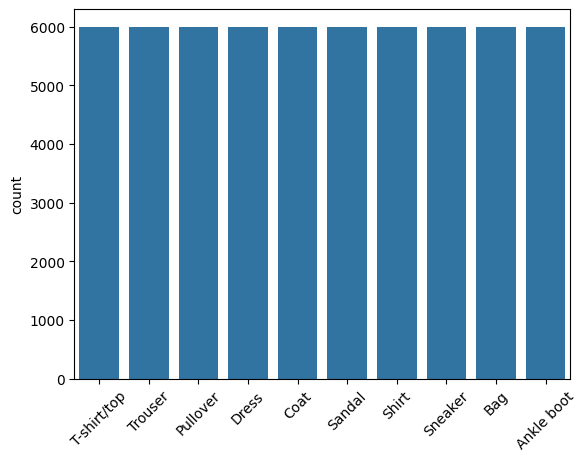

In [9]:
labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

X_train = idx2numpy.convert_from_file('.\Fashion_MNIST\TrainX').astype('float32')
y_train = idx2numpy.convert_from_file('.\Fashion_MNIST\TrainY').reshape(-1, 1)

X_test = idx2numpy.convert_from_file('.\Fashion_MNIST\TestX').astype('float32')
y_test = idx2numpy.convert_from_file('.\Fashion_MNIST\TestY').reshape(-1, 1)

X_train, X_test = X_train.reshape(-1, 1, 28, 28), X_test.reshape(-1, 1, 28, 28)

# minmax
X_max, X_min = np.max(X_train), np.min(X_train)
X_train = (X_train - X_min) / (X_max - X_min)
X_test = (X_test - X_min) / (X_max - X_min)

shuffled_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

unique_vals, indices = np.unique(y_train, return_index=True)

# Z-score
# X_mean, X_std = np.mean(X_train), np.std(X_train), 
# X_train = (X_train - X_mean)/X_std
# X_test = (X_test - X_mean)/X_std

sns.countplot(x=y_train.flatten())
plt.xticks(ticks=np.arange(10), labels=list(labels.values()), rotation=45)

# One-Hot
OneHot = OneHotEncoder(sparse_output=False).fit(y_train)
y_train_OH = OneHot.transform(y_train)
y_test_OH = OneHot.transform(y_test)

percent = 0.01
sample = np.random.choice([True, False], size=X_test.shape[0], p=[percent, 1-percent])
X_val = X_test[sample]
y_val = y_test_OH[sample]

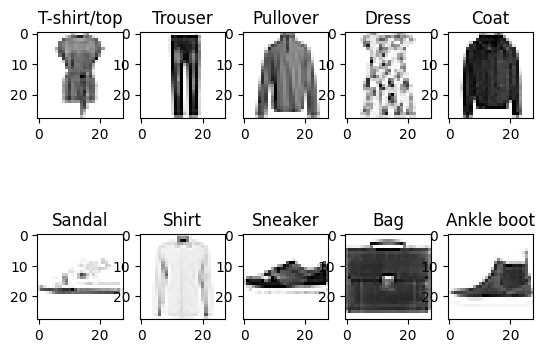

In [10]:
fig, axs = plt.subplots(2,5)

for i, idx in enumerate(indices):
    axs[np.unravel_index(i, shape=(2,5))].imshow(X_train[idx, 0], cmap='Greys')
    axs[np.unravel_index(i, shape=(2,5))].title.set_text(labels.get(y_train[idx, 0]))

### training

In [11]:
layers = [
    Conv(num_filters=5, size=5, stride=1, activation='relu'),
    Conv(num_filters=10, size=5, stride=1, activation='relu'), 
    MaxPool(size=2, stride=2, activation='relu'),
    FCL(n_inputs=1000, n_neurons=300, activation='elu'),
    FCL(n_inputs=300, n_neurons=10, activation='softmax'),
]

CNN = Main_Model(layers)

CNN.EarlyStop(monitor = "val_accuracy", min_delta = 5e-3, min_monitor=0.65, patience = 3, restore_best_layers=True)

val_step = 6_000
step = 10
CNN.train(X_train, y_train_OH, X_val, y_val, epochs=1, learning_rate=0.01, lr_decay=0.01, step=step, val_step=val_step)

In [38]:
# CNN.restore_best_layers()

In [97]:
X_axis = list( range(len(CNN.history['accuracy'][0]) ) )

tck = interpolate.splrep(X_axis, CNN.history['accuracy'][0], k = 3, s = 2)
accuracy_smoothed = interpolate.splev(X_axis, tck, der = 0)

tck = interpolate.splrep(X_axis, CNN.history['val_accuracy'][0], k = 3, s = 0.1)
val_accuracy_smoothed = interpolate.splev(X_axis[:-1], tck, der = 0)

data = [go.Scatter(x=X_axis, y = accuracy_smoothed, name = 'accuracy'),
        go.Scatter(x=X_axis[:-1], y = val_accuracy_smoothed, name = 'val_accuracy')]

layout = go.Layout(
    height = 1000,
    title = dict(
        text = 'avg accuracy per image pack',
        font_size = 30,
        x = .5
    ),
    xaxis_title = dict(
        text = 'image pack',
        font_size = 20
    ),
    yaxis_title = dict(
        text = 'accuracy',
        font_size = 20
    ),
    legend = dict(
        x = 0.02, y = .98,
        bgcolor = 'rgba(0,0,0,0)',
        font_size = 20
    ),
    margin={'r':40}
)
go.Figure(data, layout)

In [98]:
tck = interpolate.splrep(X_axis, CNN.history['loss'][0], k = 3, s = 18)
loss_smoothed = interpolate.splev(X_axis, tck, der = 0)

tck = interpolate.splrep(X_axis, CNN.history['val_loss'][0], k = 3, s = 1)
val_loss_smoothed = interpolate.splev(X_axis[:-1], tck, der = 0)

data = [go.Scatter(x=X_axis, y = loss_smoothed, name = 'loss'),
        go.Scatter(x=X_axis[:-1], y = val_loss_smoothed, name = 'val_loss')]

layout = go.Layout(
    height = 1000,
    title = dict(
        text = 'loss per image pack',
        font_size = 30,
        x = .5
    ),
    xaxis_title = dict(
        text = 'image pack',
        font_size = 20
    ),
    yaxis_title = dict(
        text = 'loss',
        font_size = 20
    ),
    legend = dict(
        x = 0.02, y = .98,
        bgcolor = 'rgba(0,0,0,0)',
        font_size = 20
    ),
    margin={'r':0}
)
go.Figure(data, layout)

In [43]:
predictions = CNN.predict(X_test[:1000])
accuracy_score(y_test[:1000].flatten(), predictions)

0.718

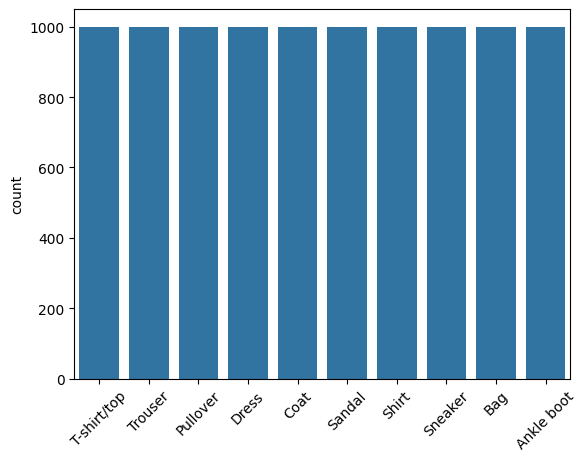

In [102]:
sns.countplot(x=y_test.flatten())
plt.xticks(ticks=np.arange(10), labels=list(labels.values()), rotation=45)
plt.show()

In [48]:
correctly_predicted = []
accuracies = []

for i in range(10):
    X_test_class = X_test[y_test.flatten() == i]
    predictions = CNN.predict(X_test_class)
    correctly_predicted.append(np.sum(predictions == i))
    accuracies.append(correctly_predicted[-1] / len(predictions))
    
correctly_predicted, accuracies = np.array(correctly_predicted), np.array(accuracies)

In [49]:
data = [
    go.Bar(x = list(labels.values()), y = correctly_predicted),
]

layout = go.Layout(
    height = 500,
    title = dict(
        text = 'Correctly predicted clothes in nums',
        font_size = 30,
        x = .5
    ),
    xaxis_title = dict(
        text = 'Clothe',
        font_size = 20
    ),
    yaxis_range = [0,1000],
    yaxis_title = dict(
        text = 'Num of predicted',
        font_size = 20
    ),
)
go.Figure(data, layout)

In [50]:
data = [
    go.Bar(x = list(labels.values()), y = accuracies*100),
]

layout = go.Layout(
    height = 500,
    title = dict(
        text = 'Accuracy on each clothe type, %',
        font_size = 30,
        x = .5
    ),
    xaxis = dict(nticks = 11),
    xaxis_title = dict(
        text = 'Clothe',
        font_size = 20
    ),
    yaxis_range = [0,100],
    yaxis=dict(ticksuffix="%"),
    yaxis_title = dict(
        text = 'Accuracy, [%]',
        font_size = 20
    ),
)
go.Figure(data, layout)

In [51]:
np.sum(accuracies)/10

0.7085

# MLP

In [64]:
layers = [
    FCL(n_inputs=784, n_neurons=64, activation='relu'),
    FCL(n_inputs=64, n_neurons=32, activation='relu'),
    FCL(n_inputs=32, n_neurons=10, activation='softmax'),
]

MLP = Main_Model(layers)

MLP.EarlyStop(monitor = "val_accuracy", min_delta = 1e-3, min_monitor=0.8, patience = 5, restore_best_layers=True)

val_step = 40000
step = 10
MLP.train(X_train, y_train_OH, X_val, y_val, epochs=5, learning_rate=0.01, lr_decay=0.0001, step=step, val_step=val_step)

[Image 40010]: Avg Acc:  76.68% | Avg Loss  0.53 | Val Acc:  76.50% | Val Loss:  0.46
[Image 40020]: Avg Acc:  91.37% | Avg Loss  0.10 | Val Acc:  76.53% | Val Loss:  0.47
[Image 40030]: Avg Acc:  72.15% | Avg Loss  0.51 | Val Acc:  77.48% | Val Loss:  0.44
[Image 40040]: Avg Acc:  76.41% | Avg Loss  0.31 | Val Acc:  78.79% | Val Loss:  0.41
[Image 40050]: Avg Acc:  61.59% | Avg Loss  0.93 | Val Acc:  78.72% | Val Loss:  0.41
[Image 40060]: Avg Acc:  89.88% | Avg Loss  0.12 | Val Acc:  78.68% | Val Loss:  0.42
[Image 40070]: Avg Acc:  72.58% | Avg Loss  0.42 | Val Acc:  78.13% | Val Loss:  0.43
[Image 40080]: Avg Acc:  70.53% | Avg Loss  0.53 | Val Acc:  78.21% | Val Loss:  0.44
[Image 40090]: Avg Acc:  64.72% | Avg Loss  0.80 | Val Acc:  77.94% | Val Loss:  0.43
[Image 40100]: Avg Acc:  80.32% | Avg Loss  0.28 | Val Acc:  78.58% | Val Loss:  0.41
[Image 40110]: Avg Acc:  89.55% | Avg Loss  0.12 | Val Acc:  78.41% | Val Loss:  0.42
[Image 40120]: Avg Acc:  83.25% | Avg Loss  0.26 | Val

In [ ]:
# MLP.restore_best_layers()

In [99]:
X_axis = list( range( len(MLP.history['accuracy'][0]) ) )

tck = interpolate.splrep(X_axis, MLP.history['accuracy'][0], k = 3, s = 45)
accuracy_smoothed = interpolate.splev(X_axis, tck, der = 0)

tck = interpolate.splrep(X_axis, MLP.history['val_accuracy'][0], k = 3, s = .3)
val_accuracy_smoothed = interpolate.splev(X_axis, tck, der = 0)

data = [go.Scatter(x=X_axis, y = accuracy_smoothed, name = 'accuracy'),
        go.Scatter(x=X_axis, y = val_accuracy_smoothed, name = 'val_accuracy')]

layout = go.Layout(
    height = 1000,
    title = dict(
        text = 'accuracy per image pack',
        font_size = 30,
        x = .5
    ),
    xaxis_title = dict(
        text = 'image pack',
        font_size = 20
    ),
    yaxis_title = dict(
        text = 'accuracy',
        font_size = 20
    ),
    legend = dict(
        x = 0.02, y = .98,
        bgcolor = 'rgba(0,0,0,0)',
        font_size = 20
    ),
    margin={'r':40}
)
go.Figure(data, layout)

In [100]:
tck = interpolate.splrep(X_axis, MLP.history['loss'][0], k = 3, s = 375)
loss_smoothed = interpolate.splev(X_axis, tck, der = 0)

tck = interpolate.splrep(X_axis, MLP.history['val_loss'][0], k = 3, s = 5)
val_loss_smoothed = interpolate.splev(X_axis, tck, der = 0)

data = [go.Scatter(x=X_axis, y = loss_smoothed, name = 'loss'),
        go.Scatter(x=X_axis, y = val_loss_smoothed, name = 'val_loss')]

layout = go.Layout(
    height = 1000,
    title = dict(
        text = 'loss per image pack',
        font_size = 30,
        x = .5
    ),
    xaxis_title = dict(
        text = 'image pack',
        font_size = 20
    ),
    yaxis_title = dict(
        text = 'loss',
        font_size = 20
    ),
    legend = dict(
        x = 0.02, y = .98,
        bgcolor = 'rgba(0,0,0,0)',
        font_size = 20
    ),
    margin={'r':0}
)
go.Figure(data, layout)

In [ ]:
# predictions = MLP.predict(X_test[:1000])
# accuracy_score(np.argmax(y_test[:1000], 1), predictions)

In [93]:
correctly_predicted = []
accuracies = []

for i in range(10):
    X_test_class = X_test[y_test.flatten() == i]
    predictions = MLP.predict(X_test_class)
    correctly_predicted.append(np.sum(predictions == i))
    accuracies.append(correctly_predicted[-1] / len(predictions))
    
correctly_predicted, accuracies = np.array(correctly_predicted), np.array(accuracies)

In [94]:
data = [
    go.Bar(x = list(labels.values()), y = correctly_predicted),
]

layout = go.Layout(
    height = 500,
    title = dict(
        text = 'Correctly predicted clothes in nums',
        font_size = 30,
        x = .5
    ),
    xaxis_title = dict(
        text = 'Clothe',
        font_size = 20
    ),
    yaxis_range = [0,1000],
    yaxis_title = dict(
        text = 'Num of predicted',
        font_size = 20
    ),
)
go.Figure(data, layout)

In [95]:
data = [
    go.Bar(x = list(labels.values()), y = accuracies*100),
]

layout = go.Layout(
    height = 500,
    title = dict(
        text = 'Accuracy on each clothe type, %',
        font_size = 30,
        x = .5
    ),
    xaxis = dict(nticks = 11),
    xaxis_title = dict(
        text = 'Clothe',
        font_size = 20
    ),
    yaxis_range = [0,100],
    yaxis=dict(ticksuffix="%"),
    yaxis_title = dict(
        text = 'Accuracy, [%]',
        font_size = 20
    ),
)
go.Figure(data, layout)

In [96]:
np.sum(accuracies)/10

0.8459999999999999

# Keras CNN

In [118]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD

In [153]:
labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

X_train = idx2numpy.convert_from_file('.\Fashion_MNIST\TrainX').astype('float32')
y_train = idx2numpy.convert_from_file('.\Fashion_MNIST\TrainY').reshape(-1, 1)

X_test = idx2numpy.convert_from_file('.\Fashion_MNIST\TestX').astype('float32')
y_test = idx2numpy.convert_from_file('.\Fashion_MNIST\TestY').reshape(-1, 1)

X_train, X_test = X_train.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1)

# minmax
X_max, X_min = np.max(X_train), np.min(X_train)
X_train = (X_train - X_min) / (X_max - X_min)
X_test = (X_test - X_min) / (X_max - X_min)

shuffled_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

unique_vals, indices = np.unique(y_train, return_index=True)

# One-Hot
OneHot = OneHotEncoder(sparse_output=False).fit(y_train)
y_train_OH = OneHot.transform(y_train)
y_test_OH = OneHot.transform(y_test)

percent = 0.01
sample = np.random.choice([True, False], size=X_test.shape[0], p=[percent, 1-percent])
X_val = X_test[sample]
y_val = y_test_OH[sample]

In [154]:
model = Sequential()
model.add(Conv2D(5, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(10, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [155]:
model.compile(
    optimizer=SGD(
        learning_rate=0.01), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

training_history = model.fit(
    X_train, y_train_OH, 
    validation_data=(X_val, y_val), 
    epochs=1, batch_size=1
)

loss, accuracy = model.evaluate(X_test, y_test_OH)

16940/60000 [=======>......................] - ETA: 1:26 - loss: 0.5800 - accuracy: 0.7852

KeyboardInterrupt: 